# MSIN0097: Predictive Analytics
________________________
# Individual Coursework: 
________________________

## Diabetic Retinopathy Detection  

### Word Count - 3548 (Excluding table of contents and appendix)

  
________________________



#### Link for GitHub Repository:
https://github.com/ankitmehani/MSIN0097_PredictiveAnalytics_2024.git



# Overview
The goal is to make a nice retinopathy model by using a pretrained inception v3 as a base and retraining some modified final layers with attention

This can be massively improved with

high-resolution images
better data sampling
ensuring there is no leaking between training and validation sets, sample(replace = True) is real dangerous
better target variable (age) normalization
pretrained models
attention/related techniques to focus on areas

In [3]:
import resource
memory_usage = resource.getrusage(resource.RUSAGE_SELF).ru_maxrss
print("Memory usage (in bytes):", memory_usage)


Memory usage (in bytes): 78266368


In [2]:
# copy the weights and configurations for the pre-trained models
!mkdir ~/.keras
!mkdir ~/.keras/models
!cp ../input/keras-pretrained-models/*notop* ~/.keras/models/
!cp ../input/keras-pretrained-models/imagenet_class_index.json ~/.keras/models/

zsh:1: no matches found: ../input/keras-pretrained-models/*notop*
cp: ../input/keras-pretrained-models/imagenet_class_index.json: No such file or directory


In [3]:
#!pip install scikit-image
#!pip install tensorflow
#!pip install --upgrade tensorflow
#!pip install scikit-learn
#!pip install keras --upgrade
#!pip install tensorflow --upgrade



##### Import necessary packages for run 

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
%matplotlib inline 
import os
from keras.utils  import to_categorical

import tensorflow as tf
from keras import backend as K
from keras.applications.inception_v3 import preprocess_input

##### Load trainLabels.csv into datafeame - retina_df 

In [5]:
base_image_dir = os.path.join('/Users/ankitmehani/VisualStudio/diabetic-retinopathy-detection/')
retina_df = pd.read_csv(os.path.join(base_image_dir, 'trainLabels.csv'))
retina_df.sample(3)


,image,level
16882,21174_left,0
27830,35254_left,2
34520,43623_left,0


#####  Below code segment prepares a DataFrame containing retinal image data for further analysis code segment prepares a DataFrame containing retinal image data for further analysis

In [6]:

#This line extracts the patient ID from the 'image' column by splitting the filename at underscores and selecting the first part. It adds this information as a new column named 'PatientId' to the DataFrame.
retina_df['PatientId'] = retina_df['image'].map(lambda x: x.split('_')[0])

#This line constructs the file paths for the images by appending the image filenames to the base directory path. It creates a new column named 'path' in the DataFrame to store these paths.
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir, 'train' ,
                                                         '{}.jpeg'.format(x)))

# Check if the image files exist at the specified paths
retina_df['exists'] = retina_df['path'].map(os.path.exists)

#This line checks if the image files exist at the paths specified in the 'path' column. It creates a new boolean column named 'exists' in the DataFrame to indicate whether each image file exists.
print(retina_df['exists'].sum(), 'images found of', retina_df.shape[0], 'total')

#1 indicates the left eye and 0 indicates the right eye.
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)



#This line encodes the 'level' column using one-hot encoding. It creates a new column named 'level_cat' in the DataFrame to store the encoded labels.
retina_df['level_cat'] = retina_df['level'].map(lambda x: to_categorical(x, 1+retina_df['level'].max()))

#This line removes any rows with missing values (NaNs) from the DataFrame.
retina_df.dropna(inplace = True)

#This line filters the DataFrame to include only the rows where the image files exist.
#retina_df = retina_df[retina_df['exists']]

#This line selects a random sample of 3 rows from the DataFrame for display.
retina_df.sample(3)


35126 images found of 35126 total


,image,level,PatientId,path,exists,eye,level_cat
34035,43039_right,0,43039,/Users/ankitmehani/VisualStudio/diabetic-retin...,True,0,"[1.0, 0.0, 0.0, 0.0, 0.0]"
12554,15745_left,0,15745,/Users/ankitmehani/VisualStudio/diabetic-retin...,True,1,"[1.0, 0.0, 0.0, 0.0, 0.0]"
23262,29418_left,3,29418,/Users/ankitmehani/VisualStudio/diabetic-retin...,True,1,"[0.0, 0.0, 0.0, 1.0, 0.0]"


##### Examine the distribution of eye and severity

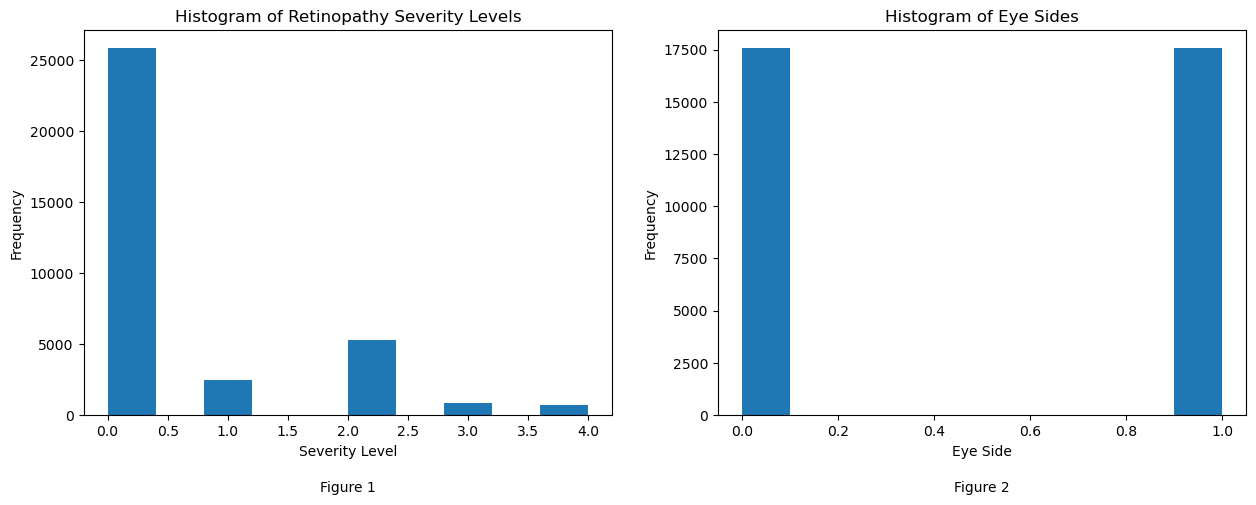

In [7]:
# Create subplots for two histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Figure 1: Histogram of Retinopathy Severity Levels
axs[0].hist(retina_df['level'])
axs[0].set_title('Histogram of Retinopathy Severity Levels')
axs[0].set_xlabel('Severity Level')
axs[0].set_ylabel('Frequency')
axs[0].text(0.5, -0.2, 'Figure 1', ha='center', transform=axs[0].transAxes)

# Figure 2: Histogram of Eye Sides
axs[1].hist(retina_df['eye'])
axs[1].set_title('Histogram of Eye Sides')
axs[1].set_xlabel('Eye Side')
axs[1].set_ylabel('Frequency')
axs[1].text(0.5, -0.2, 'Figure 2', ha='center', transform=axs[1].transAxes)

plt.show()


##### Split Data into Training and Validation

This code splits a dataset of retinal images into training and validation sets, ensuring an equal distribution of unique patient IDs and their associated severity levels in both sets. 
It then prints out the number of samples in each set for verification.

In [8]:
from sklearn.model_selection import train_test_split

rr_df = retina_df[['PatientId', 'level']].drop_duplicates()

train_ids, valid_ids = train_test_split(rr_df['PatientId'], 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = rr_df['level'])

raw_train_df = retina_df[retina_df['PatientId'].isin(train_ids)]

valid_df = retina_df[retina_df['PatientId'].isin(valid_ids)]

print('train', raw_train_df.shape[0], 'validation', valid_df.shape[0])

train 27176 validation 9632


##### Balance the distribution in the training set

Below code creates a new training dataset by sampling 75 observations from each group defined by the combination of retinopathy severity levels and eye sides, ensuring replacement. 
Afterward, it displays the sizes of both the new and original datasets for comparison. 
Finally, it generates histograms for the retinopathy severity levels and eye sides in the new training dataset.

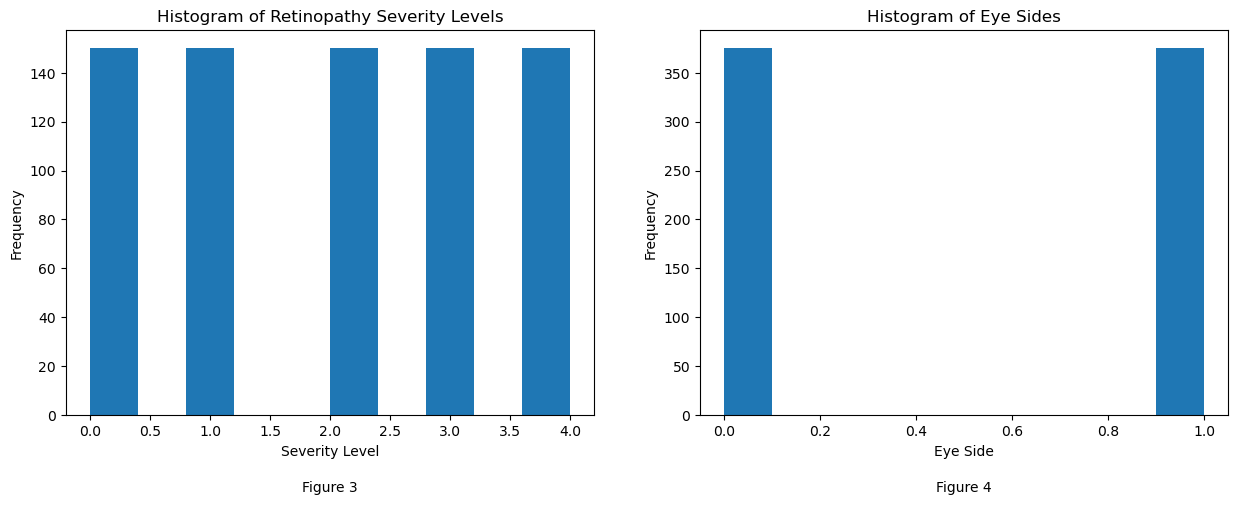

In [9]:

# Grouping and sampling
train_df = raw_train_df.groupby(['level', 'eye']).apply(lambda x: x.sample(75, replace=True)).reset_index(drop=True)

# Create subplots for two histograms
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Figure 3: Histogram of Retinopathy Severity Levels
axs[0].hist(train_df['level'])
axs[0].set_title('Histogram of Retinopathy Severity Levels')
axs[0].set_xlabel('Severity Level')
axs[0].set_ylabel('Frequency')
axs[0].text(0.5, -0.2, 'Figure 3', ha='center', transform=axs[0].transAxes)

# Figure 4: Histogram of Eye Sides
axs[1].hist(train_df['eye'])
axs[1].set_title('Histogram of Eye Sides')
axs[1].set_xlabel('Eye Side')
axs[1].set_ylabel('Frequency')
axs[1].text(0.5, -0.2, 'Figure 4', ha='center', transform=axs[1].transAxes)

plt.show()



Below code defines two TensorFlow functions for image augmentation. 
Here's a breakdown:

tf_image_loader: 
This function loads images from file paths and performs various image augmentations like flipping, brightness adjustment, saturation adjustment, hue adjustment, and contrast adjustment. It returns a function _func which applies these augmentations to input images.

tf_augmentor: 
This function further augments images using transformations such as rotation, cropping, and resizing. It creates a batch processing pipeline _create_pipeline that applies the augmentations defined in tf_image_loader to the input dataset. The augmentation parameters such as rotation range, crop probability, and intermediate transformation type are configurable.

Overall, these functions allow for efficient image augmentation pipelines in TensorFlow for tasks like deep learning model training.

In [10]:

IMG_SIZE = (512, 512) # slightly smaller than vgg16 normally expects
def tf_image_loader(out_size, 
                      horizontal_flip = True, 
                      vertical_flip = False, 
                     random_brightness = True,
                     random_contrast = True,
                    random_saturation = True,
                    random_hue = True,
                      color_mode = 'rgb',
                       preproc_func = preprocess_input,
                       on_batch = False):
    def _func(X):
        with tf.name_scope('image_augmentation'):
            with tf.name_scope('input'):
                
                X = tf.image.decode_png(tf.io.read_file(X), channels=3 if color_mode == 'rgb' else 0)

                
                X = tf.image.resize_with_pad(X, out_size[0], out_size[1]) 
            with tf.name_scope('augmentation'):
                if horizontal_flip:
                    X = tf.image.random_flip_left_right(X)
                if vertical_flip:
                    X = tf.image.random_flip_up_down(X)
                if random_brightness:
                    X = tf.image.random_brightness(X, max_delta = 0.1)
                if random_saturation:
                    X = tf.image.random_saturation(X, lower = 0.75, upper = 1.5)
                if random_hue:
                    X = tf.image.random_hue(X, max_delta = 0.15)
                if random_contrast:
                    X = tf.image.random_contrast(X, lower = 0.75, upper = 1.5)
                return preproc_func(X)
    if on_batch: 
        # we are meant to use it on a batch
        def _batch_func(X, y):
            return tf.map_fn(_func, X), y
        return _batch_func
    else:
        # we apply it to everything
        def _all_func(X, y):
            return _func(X), y         
        return _all_func
    
def tf_augmentor(out_size,
                intermediate_size = (640, 640),
                 intermediate_trans = 'crop',
                 batch_size = 16,
                   horizontal_flip = True, 
                  vertical_flip = False, 
                 random_brightness = True,
                 random_contrast = True,
                 random_saturation = True,
                    random_hue = True,
                  color_mode = 'rgb',
                   preproc_func = preprocess_input,
                   min_crop_percent = 0.001,
                   max_crop_percent = 0.005,
                   crop_probability = 0.5,
                   rotation_range = 10):
    
    load_ops = tf_image_loader(out_size = intermediate_size, 
                               horizontal_flip=horizontal_flip, 
                               vertical_flip=vertical_flip, 
                               random_brightness = random_brightness,
                               random_contrast = random_contrast,
                               random_saturation = random_saturation,
                               random_hue = random_hue,
                               color_mode = color_mode,
                               preproc_func = preproc_func,
                               on_batch=False)
    def batch_ops(X, y):
        batch_size = tf.shape(X)[0]
        with tf.name_scope('transformation'):
            # code borrowed from https://becominghuman.ai/data-augmentation-on-gpu-in-tensorflow-13d14ecf2b19
            # The list of affine transformations that our image will go under.
            # Every element is Nx8 tensor, where N is a batch size.
            transforms = []
            identity = tf.constant([1, 0, 0, 0, 1, 0, 0, 0], dtype=tf.float32)
            if rotation_range > 0:
                #angle_rad = rotation_range / 180 * np.pi
                #angles = tf.random.uniform([batch_size], -angle_rad, angle_rad)
                #transforms += [tf.raw_ops.ImageProjectiveTransformV2(angles=angles, output_shape=[intermediate_size[0], intermediate_size[1]])]
                #transforms += [tf.contrib.image.angles_to_projective_transforms(angles, intermediate_size[0], intermediate_size[1])]
                X = tf.image.rot90(X, tf.random.uniform([], 0, 4, dtype=tf.int32))

            if crop_probability > 0:
                #crop_pct = tf.random.uniform([batch_size], min_crop_percent, max_crop_percent)
                #left = tf.random.uniform([batch_size], 0, intermediate_size[0] * (1.0 - crop_pct))
                #top = tf.random.uniform([batch_size], 0, intermediate_size[1] * (1.0 - crop_pct))
                #crop_transform = tf.stack([
                #      crop_pct,
                #      tf.zeros([batch_size]), top,
                #     tf.zeros([batch_size]), crop_pct, left,
                #     tf.zeros([batch_size]),
                #      tf.zeros([batch_size])
                #  ], 1)
                #coin = tf.less(tf.random.uniform([batch_size], 0, 1.0), crop_probability)
                #transforms += [tf.where(coin, crop_transform, tf.tile(tf.expand_dims(identity, 0), [batch_size, 1]))]
                X = tf.image.random_crop(X, size=[batch_size, out_size[0], out_size[1], 3])
            if len(transforms)>0:
                X = tf.contrib.image.transform(X,
                      tf.contrib.image.compose_transforms(*transforms),
                      interpolation='BILINEAR') # or 'NEAREST'
            
            if intermediate_trans=='scale':
                 X = tf.image.resize_with_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize_with_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize(X, out_size)
            elif intermediate_trans=='crop':
                 X = tf.image.resize_with_crop_or_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize_with_crop_or_pad(X, out_size[0], out_size[1])
            #    X = tf.image.resize_image_with_crop_or_pad(X, out_size[0], out_size[1])
            else:
                raise ValueError('Invalid Operation {}'.format(intermediate_trans))
            return X, y
    def _create_pipeline(in_ds):
        batch_ds = in_ds.map(load_ops, num_parallel_calls=4).batch(batch_size)
        return batch_ds.map(batch_ops)
    return _create_pipeline


This function, named flow_from_dataframe, generates batches of augmented images and labels from a Pandas DataFrame. It uses TensorFlow Dataset operations to handle the data, shuffling if required. Augmentation is performed using a provided image data generator (idg). The function ensures thread safety during data generation.

In [11]:
def flow_from_dataframe(idg, 
                        in_df, 
                        path_col,
                        y_col, 
                        shuffle = True, 
                        color_mode = 'rgb'):
    files_ds = tf.data.Dataset.from_tensor_slices((in_df[path_col].values, 
                                                   np.stack(in_df[y_col].values,0)))
    in_len = in_df[path_col].values.shape[0]
    while True:
        if shuffle:
            files_ds = files_ds.shuffle(in_len) # shuffle the whole dataset
        
        
        next_batch = next(idg(files_ds).repeat().as_numpy_iterator())

        for i in range(max(in_len//32,1)):
            # NOTE: if we loop here it is 'thread-safe-ish' if we loop on the outside it is completely unsafe
            
            yield next_batch




This code initializes two image data generators, core_idg and valid_idg, for augmenting images during training and validation. The tf_augmentor function is used to create these generators with specified augmentation parameters such as flipping, brightness, contrast adjustments, and rotation.

These generators are then used to create TensorFlow data generators (train_gen and valid_gen) using the flow_from_dataframe function, which generates batches of augmented images and their corresponding labels from DataFrame paths. These generators are designed for training and validation data, respectively.

In [12]:
#trying to increase batchsize from 48 to 64 to faster training times.
batch_size = 48
core_idg = tf_augmentor(out_size = IMG_SIZE, 
                        color_mode = 'rgb', 
                        vertical_flip = True,
                        crop_probability=0.0, # crop doesn't work yet
                        batch_size = batch_size) 
valid_idg = tf_augmentor(out_size = IMG_SIZE, color_mode = 'rgb', 
                         crop_probability=0.0, 
                         horizontal_flip = False, 
                         vertical_flip = False, 
                         random_brightness = False,
                         random_contrast = False,
                         random_saturation = False,
                         random_hue = False,
                         rotation_range = 0,
                        batch_size = batch_size)

train_gen = flow_from_dataframe(core_idg, train_df, 
                             path_col = 'path',
                            y_col = 'level_cat')

valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col = 'path',
                            y_col = 'level_cat') # we can use much larger batches for evaluation

Below code snippet extracts a batch of validation data and labels from a generator. 

It then visualizes the images alongside their corresponding severity labels using matplotlib.
The images are displayed in a grid layout, with their severity levels indicated as titles.

This visualization aids in inspecting the validation data and understanding the model's performance.

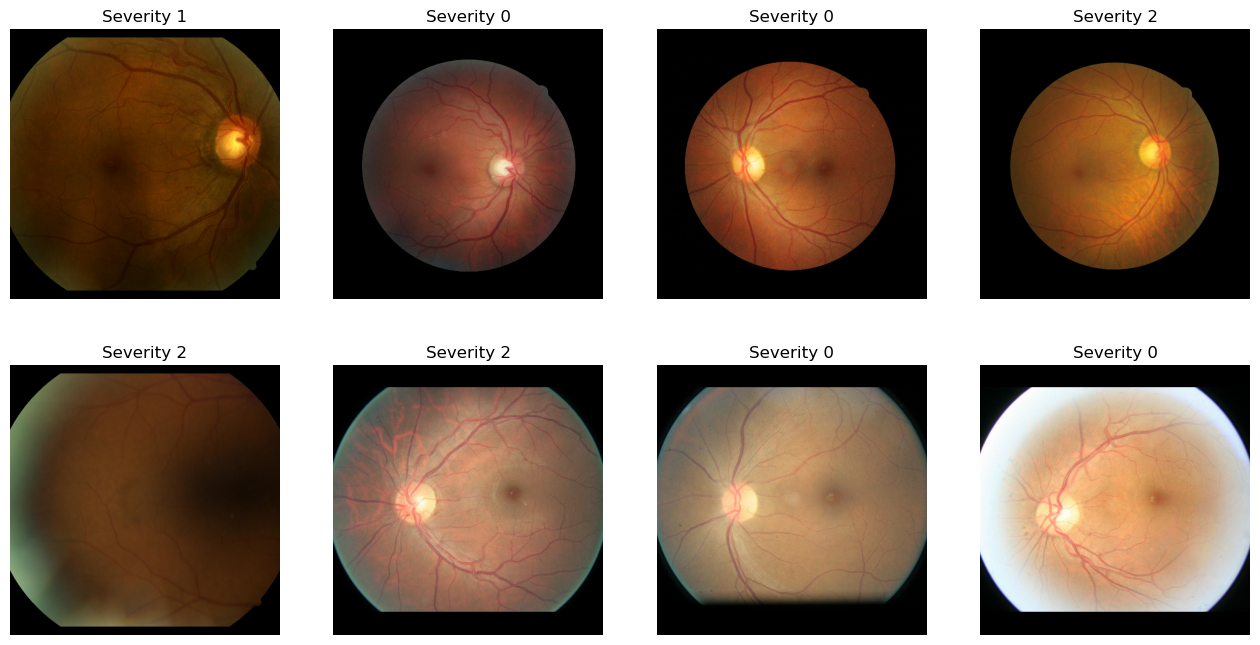

In [13]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')
plt.show()

# Training Set
These are augmented and a real mess


This code segment retrieves a batch of training data (input) and corresponding severity labels using a generator. 

 It then employs matplotlib to generate a visualization (output) where the images are presented in a grid layout.


 Each image is accompanied by its severity level, represented as a title. 
 
 This visualization aids in inspecting the training data and understanding its characteristics.

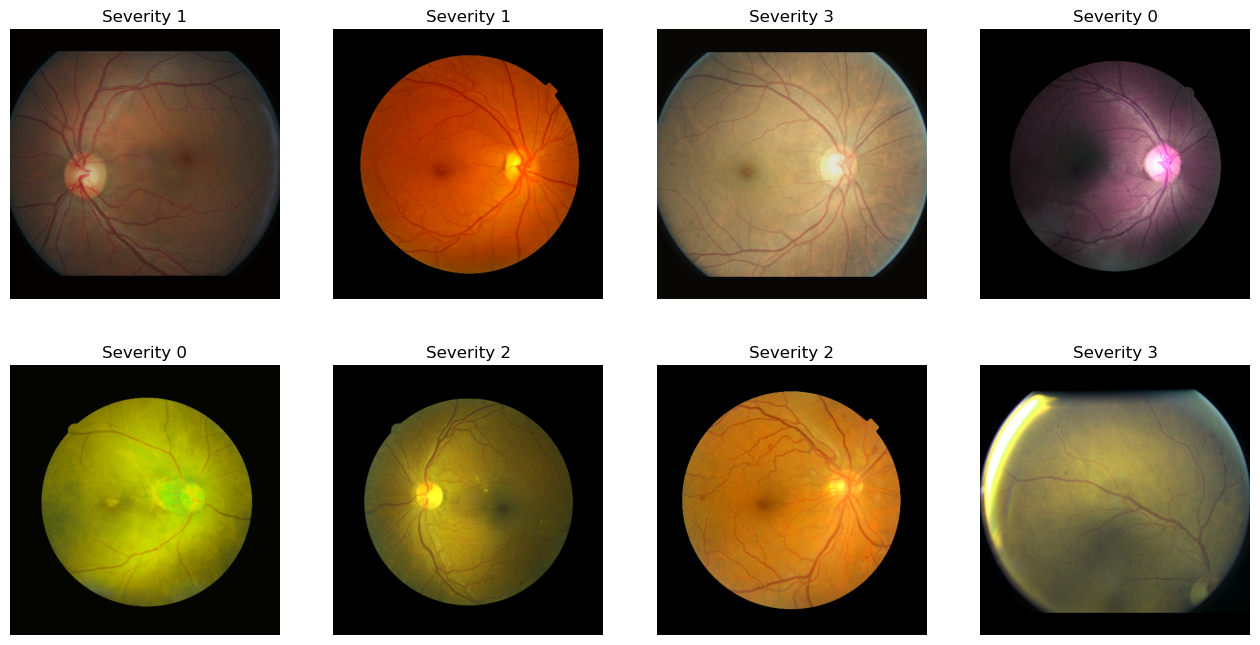

In [14]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(2, 4, figsize = (16, 8))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(np.clip(c_x*127+127, 0, 255).astype(np.uint8))
    c_ax.set_title('Severity {}'.format(np.argmax(c_y, -1)))
    c_ax.axis('off')

# Attention Model
The basic idea is that a Global Average Pooling is too simplistic since some of the regions are more relevant than others. So we build an attention mechanism to turn pixels in the GAP on an off before the pooling and then rescale (Lambda layer) the results based on the number of pixels. The model could be seen as a sort of 'global weighted average' pooling. There is probably something published about it and it is very similar to the kind of attention models used in NLP. It is largely based on the insight that the winning solution annotated and trained a UNET model to segmenting the hand and transforming it. This seems very tedious if we could just learn attention.

In [15]:
import keras
print(keras.__version__)


3.1.1


This code segment constructs a CNN model with an attention mechanism for image classification tasks, leveraging pre-trained CNN architectures for feature extraction and incorporating regularization techniques for improved generalization

Here's a breakdown of what each line does:
1. Importing Dependencies
2. Input Layer
3. Base Pre-trained Model
4. Batch Normalization
5. Attention Mechanism
6. Global Average Pooling
7. Rescale Global Average Pooling
8. Dropout and Dense Layers
9. Output Layer
10. Model Compilation
11. Summary

In [16]:
# Importing Dependencies: Imports necessary modules from Keras for building the model
from keras.applications.vgg16 import VGG16 as PTModel
from keras.applications.inception_resnet_v2 import InceptionResNetV2 as PTModel
from keras.applications.inception_v3 import InceptionV3 as PTModel
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Input, Conv2D, multiply, Lambda
from keras.models import Model
from keras.layers import BatchNormalization
from keras.initializers import Constant
from keras.metrics import top_k_categorical_accuracy


#Input Layer: Defines an input layer with the shape of the input data (t_x).

in_lay = Input(t_x.shape[1:])



#Base Pre-trained Model: Initializes a pre-trained CNN model (VGG16, InceptionResNetV2, or InceptionV3) without the top classification layers. 
#                        The model's weights are initialized with ImageNet weights.


base_pretrained_model = PTModel(input_shape=t_x.shape[1:], include_top=False, weights='imagenet')
base_pretrained_model.trainable = False
pt_depth = base_pretrained_model.output_shape[-1]
pt_features = base_pretrained_model(in_lay)


#Batch Normalization: Adds batch normalization to the extracted features from the pre-trained model.

bn_features = BatchNormalization()(pt_features)


#Attention Mechanism: Constructs an attention mechanism using convolutional layers to focus on specific regions of the image
#                     (attention mechanism to turn pixels in the GAP on an off)

attn_layer = Conv2D(64, kernel_size = (1,1), padding = 'same', activation = 'relu')(Dropout(0.5)(bn_features))
attn_layer = Conv2D(16, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(8, kernel_size = (1,1), padding = 'same', activation = 'relu')(attn_layer)
attn_layer = Conv2D(1, 
                    kernel_size = (1,1), 
                    padding = 'valid', 
                    activation = 'sigmoid')(attn_layer)
# fan it out to all of the channels
up_c2_w = np.ones((1, 1, 1, pt_depth))

up_c2 = Conv2D(pt_depth, kernel_size=(1, 1), padding='same', 
               activation='linear', use_bias=False, 
               kernel_initializer=Constant(up_c2_w))

up_c2.trainable = False
attn_layer = up_c2(attn_layer)

mask_features = multiply([attn_layer, bn_features])


# Global Average Pooling: Performs global average pooling on the masked features and attention mask separately.
gap_features = GlobalAveragePooling2D()(mask_features)
gap_mask = GlobalAveragePooling2D()(attn_layer)

#Rescale Global Average Pooling: Scales the global average pooled features by the attention mask to handle missing values.
gap = Lambda(lambda x: x[0]/x[1], name = 'RescaleGAP')([gap_features, gap_mask])

#Dropout and Dense Layers: Applies dropout regularization and dense layers for feature transformation.
gap_dr = Dropout(0.25)(gap)
dr_steps = Dropout(0.25)(Dense(128, activation = 'relu')(gap_dr))

#Output Layer: Adds a dense output layer with softmax activation for multi-class classification.
out_layer = Dense(t_y.shape[-1], activation = 'softmax')(dr_steps)

#Model Compilation: Compiles the model with the Adam optimizer, categorical cross-entropy loss function, and evaluation metrics.
retina_model = Model(inputs = [in_lay], outputs = [out_layer])

def top_2_accuracy(in_gt, in_pred):
    return top_k_categorical_accuracy(in_gt, in_pred, k=2)

retina_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy',
                           metrics = ['categorical_accuracy', top_2_accuracy])

#Summary: Displays a summary of the constructed model architecture, including layer names, output shapes, and parameter counts.
retina_model.summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 14, 14,    │ 21,802,784 │ input_layer[0][0] │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │      8,192 │ inception_v3[0][… │
│ (BatchNormalizatio… │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 14, 14,    │          0 │ batch_normalizat… │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_94 (Conv2D)  │ (None, 14, 14,    │    131,136 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_95 (Conv2D)  │ (None, 14, 14,    │      1,040 │ conv2d_94[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_96 (Conv2D)  │ (None, 14, 14, 8) │        136 │ conv2d_95[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_97 (Conv2D)  │ (None, 14, 14, 1) │          9 │ conv2d_96[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_98 (Conv2D)  │ (None, 14, 14,    │      2,048 │ conv2d_97[0][0]   │
│                     │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 14, 14,    │          0 │ conv2d_98[0][0],  │
│                     │ 2048)             │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ multiply[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ conv2d_98[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ RescaleGAP (Lambda) │ (None, 2048)      │          0 │ global_average_p… │
│                     │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2048)      │          0 │ RescaleGAP[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    262,272 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 5)         │        645 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 22,208,262 (84.72 MB)

 Trainable params: 401,382 (1.53 MB)

 Non-trainable params: 21,806,880 (83.19 MB)

The above Layer Information table displays information about each layer in the neural network. It includes the following columns:

Layer (type): This column specifies the type of each layer in the network.
Output Shape: Indicates the shape of the output produced by each layer.
Param #: Represents the number of trainable parameters in each layer.
Connected to: Describes how each layer is connected to other layers in the network.


Each row in the table corresponds to a layer in the neural network, and the layers are arranged sequentially based on their order in the model architecture. Additionally, the model summary provides insights into the overall size of the model and the distribution of trainable and non-trainable parameters, which can be useful for understanding the complexity of the network and its memory requirements.


This code sets up callback functions in Keras for monitoring and controlling the training process of a neural network model:

1. ModelCheckpoint: Saves the best model weights based on validation loss to a specified file path.

2. ReduceLROnPlateau: Reduces the learning rate when the validation loss plateaus, aiming to improve training convergence.

3. EarlyStopping: Stops training if the validation loss doesn't improve after a specified number of epochs, preventing overfitting.

These callbacks are then compiled into a list (callbacks_list) and used during the model training phase to optimize model performance and prevent overfitting.

In [17]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

#weight_path - retina_weights.best.hdf5
weight_path="{}_weights.best.weights.h5".format('retina')


checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, verbose=1, mode='auto', epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=6) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

We are executing !rm -rf ~/.keras to clean up the .keras directory before starting training, which helps ensure a clean slate for the training process, preventing any potential conflicts or issues arising from previous configurations or cached files.

In [18]:
!rm -rf ~/.keras # clean up before starting training

This code trains the retina_model using the provided generators train_gen for training data and valid_gen for validation data. 
It specifies the number of steps per epoch and validation steps based on the batch size and the size of the respective datasets. 
Additionally, it sets the number of epochs to 5 and includes a list of callbacks for monitoring the training process, such as model checkpointing, early stopping, and reducing the learning rate on plateau.


In [19]:
model_fit_history = retina_model.fit(train_gen, 
                 steps_per_epoch=train_df.shape[0] // batch_size,
                 validation_data=valid_gen, 
                 validation_steps=valid_df.shape[0] // batch_size,
# 28/03/2024 Run 1 - Initially took epochs as 30 but fitting took too much because of iterative/recursive runs and kernel aborted during prediction.
#Hence updated epochs as 1 , later will try with more than 1.
#28/03/2024 Run2 2 - Modified epochs to 5.
#28/03/2024 Run2 2 - Modified epochs to 10.

                 epochs= 1, 
                 callbacks=callbacks_list
                )



15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - categorical_accuracy: 0.6767 - loss: 0.9350 - top_2_accuracy: 0.8211
Epoch 1: val_loss improved from inf to 1.98856, saving model to retina_weights.best.weights.h5
15/15 ━━━━━━━━━━━━━━━━━━━━ 754s 53s/step - categorical_accuracy: 0.6886 - loss: 0.9075 - top_2_accuracy: 0.8281 - val_categorical_accuracy: 0.1458 - val_loss: 1.9886 - val_top_2_accuracy: 0.2708 - learning_rate: 0.0010


In [20]:
import pandas as pd

# Convert the history object to a DataFrame
history_df = pd.DataFrame(model_fit_history.history)

# Print the DataFrame as a Markdown table
print(history_df.to_markdown())


|    |   categorical_accuracy |     loss |   top_2_accuracy |   val_categorical_accuracy |   val_loss |   val_top_2_accuracy |   learning_rate |
|---:|-----------------------:|---------:|-----------------:|---------------------------:|-----------:|---------------------:|----------------:|
|  0 |               0.868056 | 0.495809 |         0.933333 |                   0.145833 |    1.98856 |             0.270833 |           0.001 |


In [21]:
# Load the best version of the model
retina_model.load_weights(weight_path)

In [22]:
# Save the model using the native Keras format
retina_model.save('full_retina_model_300324_V1.keras')


from keras.models import load_model

# Load the model with safe_mode=False to disable safe mode
retina_model = load_model('full_retina_model_300324_V1.keras', compile=False, safe_mode=False)

# Now you can use the model for prediction or further training


This code is populating test_X and test_Y arrays with the entire validation dataset, batch by batch, by iterating over the validation generator and tracking progress with a tqdm progress bar.

In [23]:
from tqdm.notebook import tqdm


#This creates a new generator valid_gen using the flow_from_dataframe function, which generates batches of data from the validation dataframe (valid_df). 
#This generator will yield batches of input data (c_x) and corresponding target data (c_y).

# fresh valid gen
valid_gen = flow_from_dataframe(valid_idg, valid_df, 
                             path_col='path',
                             y_col='level_cat') 

#calculates the number of batches (vbatch_count) based on the size of the validation dataframe and the specified batch size.
vbatch_count = (valid_df.shape[0] // batch_size - 1)
out_size = vbatch_count * batch_size

#initialize NumPy arrays test_X and test_Y to store the input and target data for validation.
test_X = np.zeros((out_size,) + t_x.shape[1:], dtype=np.float32)
test_Y = np.zeros((out_size,) + t_y.shape[1:], dtype=np.float32)

#Iterates over the batches of data yielded by valid_gen, with the loop counter i and the corresponding data c_x and c_y.
for i, (c_x, c_y) in zip(tqdm(range(vbatch_count)), valid_gen):
    #Computes the starting index j for storing the current batch of data in the test_X and test_Y arrays.
    j = i * batch_size
    #assigns the current batch of input data c_x and target data c_y to the appropriate slices of the test_X and test_Y arrays.
    test_X[j:(j + c_x.shape[0])] = c_x
    test_Y[j:(j + c_x.shape[0])] = c_y


  0%|          | 0/199 [00:00<?, ?it/s]

## Show Attention
Did our attention model learn anything useful?

This code iterates over the layers of a neural network model (retina_model) starting from the second layer. For each layer, it performs the following steps:

1. Checks if the previous layer is an input layer. If so, it skips to the next layer.
2. Retrieves the output shape of the previous layer (prev_layer_output_shape).
3. Retrieves the current layer.
4. Checks if the output shape of the previous layer has 4 dimensions (indicating a convolutional layer). 
If it does and the last dimension is 1, it prints information about the previous layer's output shape and the current layer, and then breaks out of the loop.

In summary, this code is finding the first convolutional layer in the model that has an output shape with 4 dimensions and a depth of 1, and it prints information about that layer.

In [24]:
retina_model.layers

[<InputLayer name=input_layer, built=True>,
 <Functional name=inception_v3, built=True>,
 <BatchNormalization name=batch_normalization_94, built=True>,
 <Dropout name=dropout, built=True>,
 <Conv2D name=conv2d_94, built=True>,
 <Conv2D name=conv2d_95, built=True>,
 <Conv2D name=conv2d_96, built=True>,
 <Conv2D name=conv2d_97, built=True>,
 <Conv2D name=conv2d_98, built=True>,
 <Multiply name=multiply, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d, built=True>,
 <GlobalAveragePooling2D name=global_average_pooling2d_1, built=True>,
 <Lambda name=RescaleGAP, built=True>,
 <Dropout name=dropout_1, built=True>,
 <Dense name=dense, built=True>,
 <Dropout name=dropout_2, built=True>,
 <Dense name=dense_1, built=True>]

for i in range(1, len(retina_model.layers)):
    if isinstance(retina_model.layers[i - 1], tf.keras.layers.InputLayer):
        continue  # This continue statement should be inside a loop
    prev_layer_output_shape = retina_model.layers[i - 1].output[0].shape
    current_layer = retina_model.layers[i]
    if len(prev_layer_output_shape) == 4:
        if prev_layer_output_shape[-1]==1:
            print("Previous layer output shape:", prev_layer_output_shape)
            print("Current layer:", current_layer)
            break


In [25]:

# Iterate over layers starting from the second layer
for i in range(1, len(retina_model.layers)):
    if isinstance(retina_model.layers[i - 1], tf.keras.layers.InputLayer):
        continue
    prev_layer_output_shape = retina_model.layers[i - 1].output.shape
    current_layer = retina_model.layers[i]
    if len(prev_layer_output_shape) == 4:
        if prev_layer_output_shape[-1]==1:
            print("Previous layer output shape:", prev_layer_output_shape)
            print("Current layer:", current_layer)
            break


Previous layer output shape: (None, 14, 14, 1)
Current layer: <Conv2D name=conv2d_98, built=True>


In [26]:
attn_layer

<KerasTensor shape=(None, 14, 14, 2048), dtype=float32, sparse=False, name=keras_tensor_319>

this code snippet helps identify the attention layer within the model based on its output shape, specifically looking for layers with a shape of (None, None, None, 1)

In [27]:
# Iterate through the layers of the model and print their names and indices
for i, layer in enumerate(retina_model.layers):
    print(f"Layer {i}: {layer.name}")

# Identify the attention layer by its name and retrieve its index
attn_layer_name = "conv2d_98"  
attn_layer_index = None
for i, layer in enumerate(retina_model.layers):
    if layer.name == attn_layer_name:
        attn_layer_index = i
        break

if attn_layer_index is not None:
    print(f"The index of the attention layer '{attn_layer_name}' is: {attn_layer_index}")
else:
    print(f"Attention layer '{attn_layer_name}' not found in the model.")


Layer 0: input_layer
Layer 1: inception_v3
Layer 2: batch_normalization_94
Layer 3: dropout
Layer 4: conv2d_94
Layer 5: conv2d_95
Layer 6: conv2d_96
Layer 7: conv2d_97
Layer 8: conv2d_98
Layer 9: multiply
Layer 10: global_average_pooling2d
Layer 11: global_average_pooling2d_1
Layer 12: RescaleGAP
Layer 13: dropout_1
Layer 14: dense
Layer 15: dropout_2
Layer 16: dense_1
The index of the attention layer 'conv2d_98' is: 8


This code generates and visualizes attention maps for a set of randomly selected images from the test dataset.

This code is performing the following tasks:
1. Random Index Selection
2. Model Setup
3. Function Definition (attn_func)
4. Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 790ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


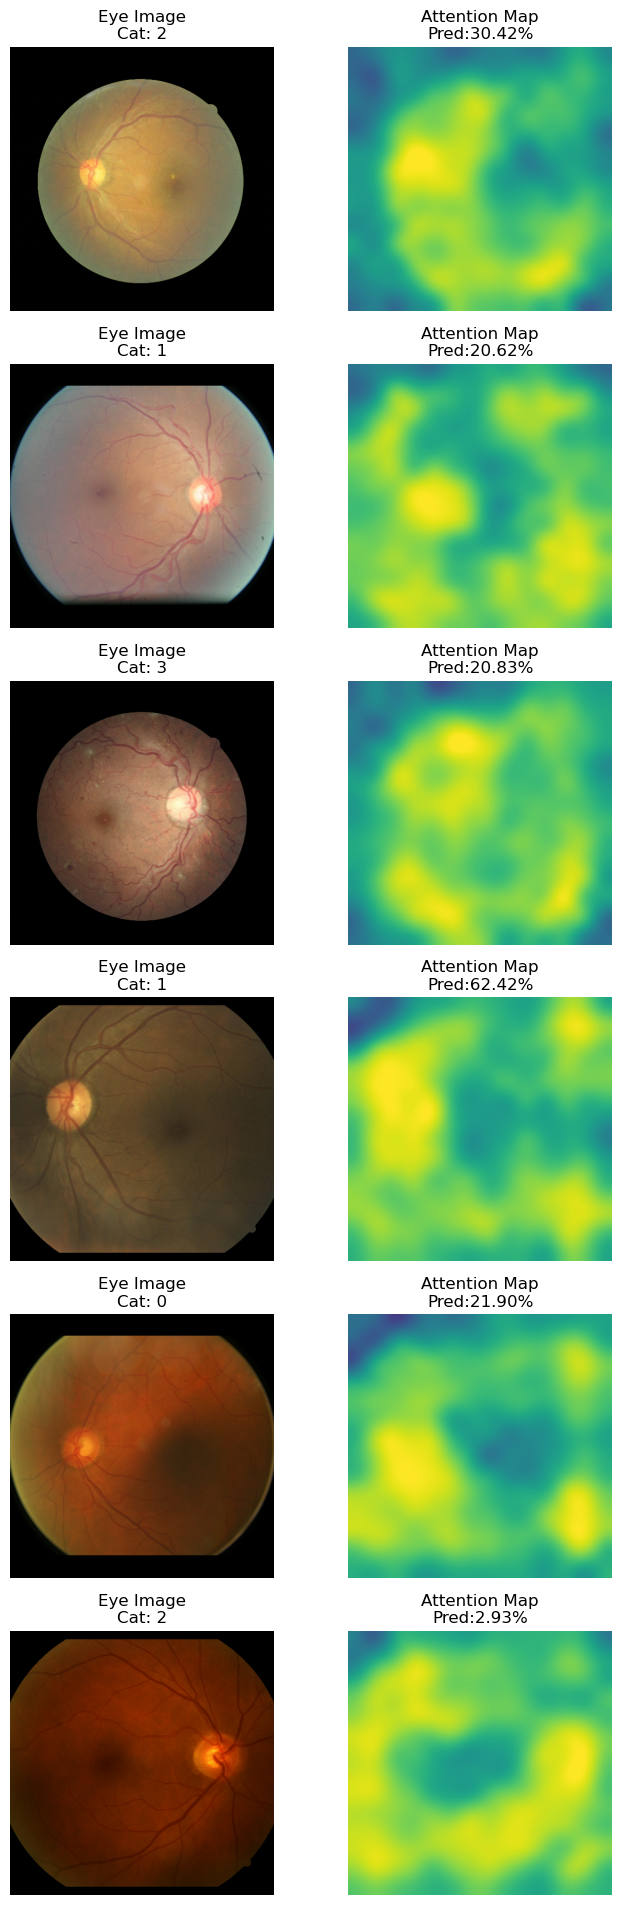

In [28]:
from tensorflow.keras.models import Model
from tensorflow.python.keras import backend as K


# 1. Random Index Selection - randomly selects six indices (rand_idx) from the range of indices of the test_X array
rand_idx = np.random.choice(range(len(test_X)), size = 6)


# 2. Model Setup 

# new model (attn_model) that outputs the activations of the attention layer (attn_layer_output) from the original model (retina_model).
# attn_model is defined using the same input as the retina_model and outputs the activations of the attention layer.
#  attn_model is compiled with the same optimizer and loss function as the retina_model

# Get the underlying Keras layer from the KerasTensor object
attn_layer_output = attn_layer

# Define a new model that outputs the activations of the desired layer
attn_model = Model(inputs=retina_model.input, outputs=attn_layer_output)

# Compile the new model with the same optimizer and loss function as the original model
attn_model.compile(optimizer=retina_model.optimizer, loss=retina_model.loss)

# 3. Function Definition
# (attn_func) to get the output of the attention layer by using the predict method on the attn_model
#This function takes an input image and returns the attention map generated by the attention layer.

# Create the function to get the output of the attention layer
def attn_func(input_image):
    return attn_model.predict(input_image)


# 4. Visualization:
    #For each index, it:
        #-->Retrieves the corresponding image from the test_X array.
        #-->Computes the attention map using the attn_func.
        #-->Visualizes the original image and its attention map side by side.
        #-->Sets titles for both subplots, indicating the real category of the image and the predicted category based on the attention map.

    #The resulting figure is saved as 'attention_map.png' with a high DPI (dots per inch).

fig, m_axs = plt.subplots(len(rand_idx), 2, figsize = (8, 4*len(rand_idx)))

[c_ax.axis('off') for c_ax in m_axs.flatten()]
for c_idx, (img_ax, attn_ax) in zip(rand_idx, m_axs):
    cur_img = test_X[c_idx:(c_idx+1)]
    attn_img = attn_func(cur_img)
    img_ax.imshow(np.clip(cur_img[0,:,:,:]*127+127, 0, 255).astype(np.uint8))
    attn_ax.imshow(attn_img[0, :, :, 0]/attn_img[0, :, :, 0].max(), cmap = 'viridis', 
                   vmin = 0, vmax = 1, 
                   interpolation = 'lanczos')
    real_cat = np.argmax(test_Y[c_idx, :])
    img_ax.set_title('Eye Image\nCat:%2d' % (real_cat))
    pred_cat = retina_model.predict(cur_img)
    attn_ax.set_title('Attention Map\nPred:%2.2f%%' % (100*pred_cat[0,real_cat]))

fig.savefig('attention_map.png', dpi = 300)

## Evaluate the results
Here we evaluate the results by loading the best version of the model and seeing how the predictions look on the results. We then visualize spec

This code evaluates a machine learning model's performance on a test dataset:

1. It predicts class probabilities for test samples.
2. Converts these probabilities to class labels.
3. Computes accuracy, comparing predicted and true labels.
4. Prints accuracy percentage and a detailed classification report with precision, recall, F1-score, and support for each class.

In [29]:
from sklearn.metrics import accuracy_score, classification_report
pred_Y = retina_model.predict(test_X, batch_size = 1 , verbose = True)
pred_Y_cat = np.argmax(pred_Y, -1)
test_Y_cat = np.argmax(test_Y, -1)
print('Accuracy on Test Data: %2.2f%%' % (accuracy_score(test_Y_cat, pred_Y_cat)))
print(classification_report(test_Y_cat, pred_Y_cat))

: 

Summarized breakdown of the provided results on Run 1 - 27/03/2024:

1. Progress Indicator:
The evaluation processed 9552 steps in total, taking approximately 921 seconds to complete.
The average time taken per step was around 96 milliseconds.

2. Accuracy on Test Data:
The model achieved an overall accuracy of 0.27% on the test dataset.

3. Warnings:
Warning messages indicated that precision, recall, and F1-score were ill-defined for certain classes due to no predicted or true samples for those classes.
The warning suggested using the zero_division parameter to control this behavior.

Overall, the results provide a comprehensive overview of the model's performance on the test dataset, including accuracy and detailed class-wise performance metrics, while also alerting about any encountered issues during the evaluation process.

Heatmap visualization of a confusion matrix, which compares the actual (test_Y_cat) and predicted (pred_Y_cat) class labels.

Each cell in the heatmap represents the number of samples that were classified into a particular class.

The heatmap is annotated with these values, and a color gradient (blue) is used to indicate the intensity of the values.

Additionally, the vmax parameter is set to limit the maximum value of the color scale based on the size of the test dataset.

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

sns.heatmap(confusion_matrix(test_Y_cat, pred_Y_cat), 
            annot=True, fmt="d", cbar = False, cmap = plt.cm.Blues, vmax = test_X.shape[0]//16)

## ROC Curve for healthy vs sick
Here we make an ROC curve for healthy (severity == 0) and sick (severity>0) to see how well the model works at just identifying the disease

This code calculates the Receiver Operating Characteristic (ROC) curve and the Area Under the Curve (AUC) score for binary classification. It first determines whether a patient is sick (positive class) based on the test labels (test_Y_cat). Then, it calculates a sickness score (sick_score) by summing the predicted probabilities of being sick (class > 0) from the model predictions (pred_Y).

Next, it computes the false positive rate (fpr) and true positive rate (tpr) using the roc_curve function from sklearn.metrics. These rates are plotted against each other to generate the ROC curve.

Additionally, it plots a diagonal line (green) representing random guessing and labels it accordingly. Finally, it displays the ROC curve and the AUC score on the plot.

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

sick_vec = test_Y_cat>0
sick_score = np.sum(pred_Y[:,1:],1)
fpr, tpr, _ = roc_curve(sick_vec, sick_score)
fig, ax1 = plt.subplots(1,1, figsize = (6, 6), dpi = 150)
ax1.plot(fpr, tpr, 'b.-', label = 'Model Prediction (AUC: %2.2f)' % roc_auc_score(sick_vec, sick_score))
ax1.plot(fpr, fpr, 'g-', label = 'Random Guessing')
ax1.legend()
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate');

This generates a grid of subplots (2 rows and 4 columns) and displays images along with their corresponding actual severity levels and predicted probabilities.

1. Each subplot (c_ax) displays an image from the test dataset (test_X) along with its clipped intensity values scaled to the range [0, 255] and converted to unsigned integers (np.uint8).

2. The title of each subplot contains:
    
    a. The actual severity level (test_Y_cat[idx]) of the image.
    
    b. Predicted probabilities for each severity level, sorted in descending order. Each severity level is represented by a number (k), its corresponding probability percentage (v), and 
    a visual representation of the probability using asterisks. The severity levels are sorted based on their predicted probabilities.

3. The axis for each subplot is turned off to remove axis ticks and labels.


Finally, the plot is saved as an image file named "trained_img_predictions.png" with a resolution of 300 dots per inch (dpi).

In [ ]:
fig, m_axs = plt.subplots(2, 4, figsize = (32, 20))
for (idx, c_ax) in enumerate(m_axs.flatten()):
    c_ax.imshow(np.clip(test_X[idx]*127+127,0 , 255).astype(np.uint8), cmap = 'bone')
    c_ax.set_title('Actual Severity: {}\n{}'.format(test_Y_cat[idx], 
                                                           '\n'.join(['Predicted %02d (%04.1f%%): %s' % (k, 100*v, '*'*int(10*v)) for k, v in sorted(enumerate(pred_Y[idx]), key = lambda x: -1*x[1])])), loc='left')
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png', dpi = 300)